Found 6500 files belonging to 4 classes.
Found 724 files belonging to 4 classes.


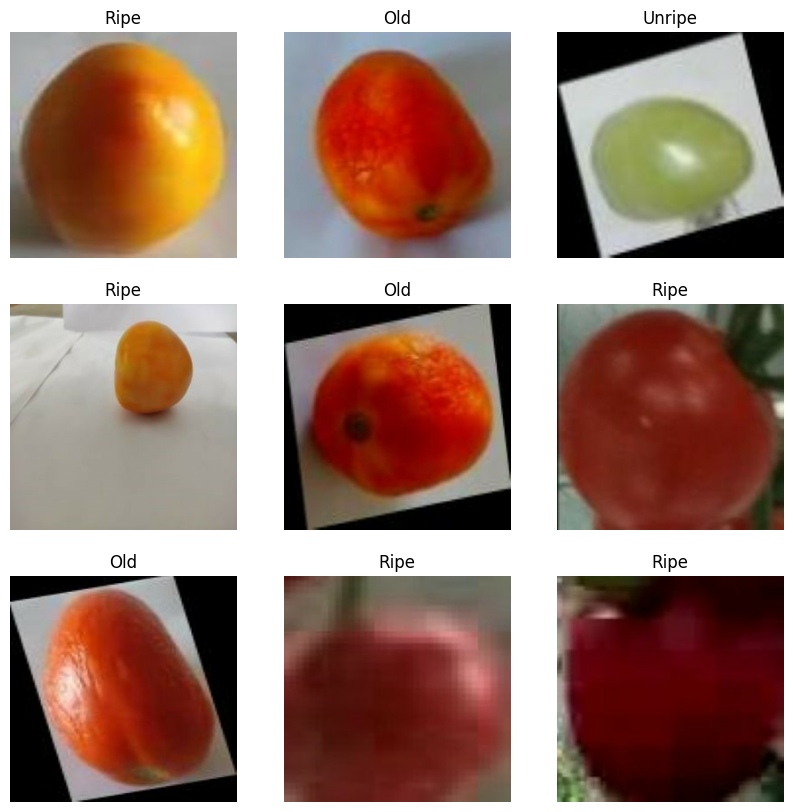

In [20]:
import tensorflow as tf
import matplotlib.pyplot as plt


# Load dataset
train_dir = 'content/ieee-mbl-cls/train'
validation_dir = 'content/ieee-mbl-cls/val'

BATCH_SIZE = 32
IMG_SIZE = (256, 256)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [21]:
# Creating test set 
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

# Performance configurations
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

Number of validation batches: 19
Number of test batches: 4


2025-05-03 12:33:02.329319: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


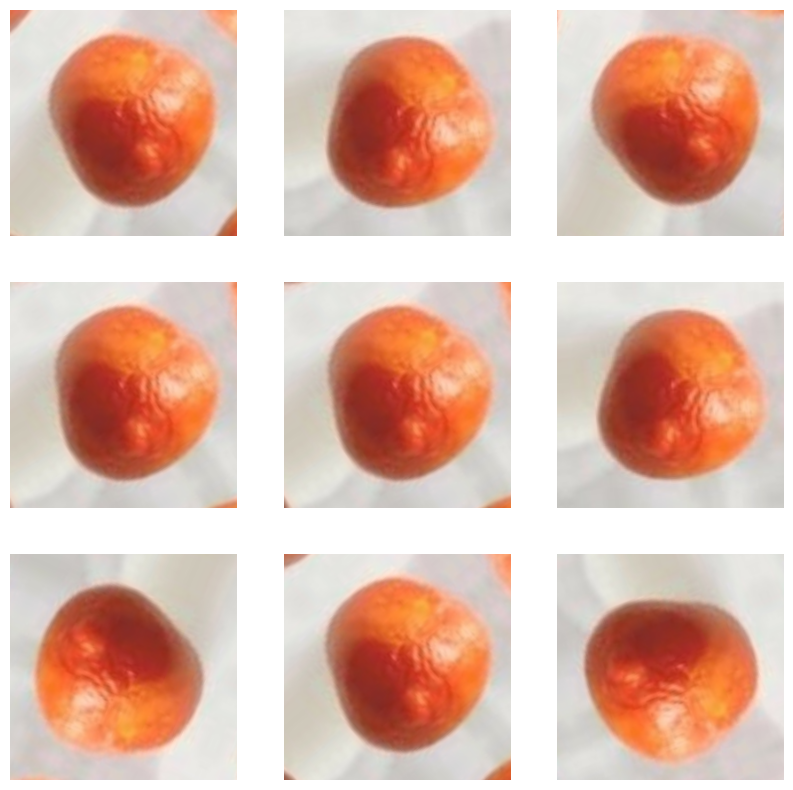

In [22]:
# Data augmentation
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal_and_vertical'),
  tf.keras.layers.RandomRotation(0.2),
])

for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [ ]:
# Load and set up base model
from tensorflow.keras.applications import efficientnet_v2, preprocess_input
from tensorflow.keras import layers, models, optimizers

# Load with pre-trained weights
base_model = efficientnet_v2.EfficientNetV2B0(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
base_model.trainable = False

# Build full model
inputs = tf.keras.Input(shape=(256, 256, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(4, activation='softmax')(x)  # 4-class output

model = models.Model(inputs, outputs)

model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetv2-b0 (Functional)  │ (None, 8, 8, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,083,796 (23.21 MB)

 Trainable params: 164,484 (642.52 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 301ms/step - accuracy: 0.3231 - loss: 1.3553
initial loss: 1.35
initial accuracy: 0.31
Epoch 1/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 74s 335ms/step - accuracy: 0.6566 - loss: 0.9243 - val_accuracy: 0.8876 - val_loss: 0.3391
Epoch 2/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 71s 350ms/step - accuracy: 0.8840 - loss: 0.3434 - val_accuracy: 0.9094 - val_loss: 0.2410
Epoch 3/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 66s 324ms/step - accuracy: 0.9091 - loss: 0.2628 - val_accuracy: 0.9312 - val_loss: 0.1971
Epoch 4/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 62s 304ms/step - accuracy: 0.9157 - loss: 0.2349 - val_accuracy: 0.9446 - val_loss: 0.1589
Epoch 5/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 62s 305ms/step - accuracy: 0.9217 - loss: 0.2090 - val_accuracy: 0.9480 - val_loss: 0.1540
Epoch 6/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 63s 310ms/step - accuracy: 0.9257 - loss: 0.1900 - val_accuracy: 0.9480 - val_loss: 0.1531
Epoch 7/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 63s 309ms/step - accuracy: 0.9343 - loss: 0.1768 - val_ac

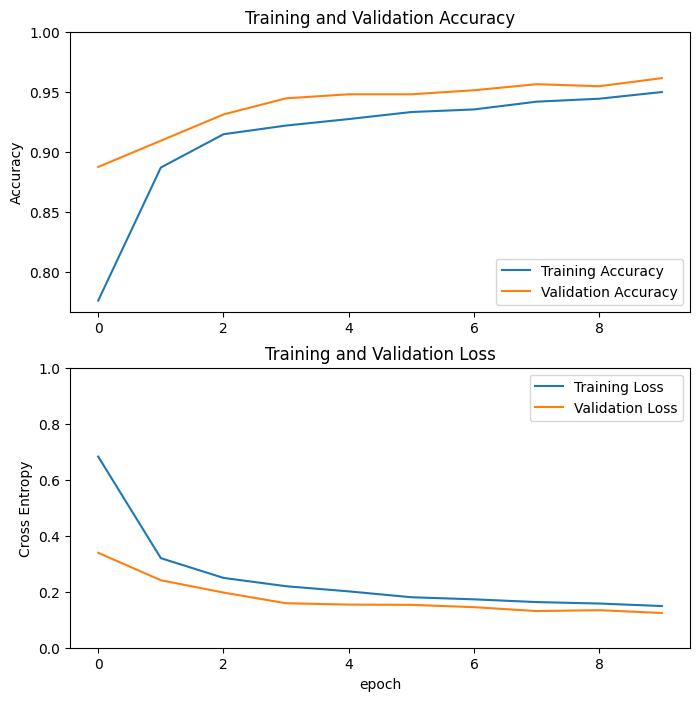

In [24]:
# Compile and train
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=initial_epochs  # Start with 10, increase if needed
)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Predictions:
 [1 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 1 0 0 0
 1 0 0 0 1 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 1 0 0 0 1 0 0 1 0
 0 0 1 0 0 0 0 0 0 1 0 0 1 0 0 1 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0
 1 0 1 0 0 0 1 0 0 0 0 0 1 0 1 0 0]
Labels:
 [0 2 3 2 0 3 2 3 1 1 1 0 1 3 2 3 1 1 0 0 3 2 1 0 2 1 3 3 1 1 3 1]


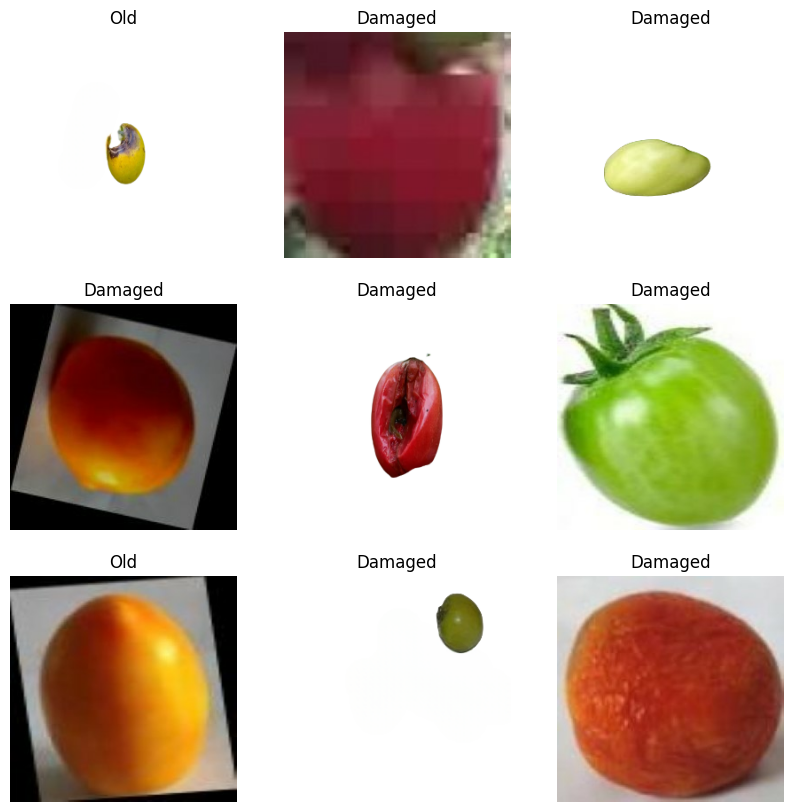

In [ ]:
# Test validation

# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
# Predict on batch
pred_probs = model.predict_on_batch(image_batch)  # shape: (batch_size, 4)
pred_class_indices = tf.argmax(pred_probs, axis=1).numpy()  # get most probable class

# Display predictions vs ground truth
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    pred_label = class_names[pred_class_indices[i]]
    true_label = class_names[label_batch[i]]
    plt.title(f"Pred: {pred_label}\nTrue: {true_label}")
    plt.axis("off")
